In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Keras

[Keras](https://keras.io/) 是一種較 Tensorflow 更高階的深度學習框架，可以使用更少量的程式碼來建立深度學習模型，可以先熟悉 [Tensorflow 單元](/notebooks/unit/tensorflow/tenforflow.ipynb)後再來閱讀本單元。Keras 使用更低階的深度學習框架作為後端引擎，目前支援如 CNTK、Tensorflow、Theano 等知名框架。本單元將介紹 Keras 中 Model 與 Layer 的用法，並實作一個圖片分類器。

## 1. Model & Layer

在 Keras，可以宣告一個 [Model](https://keras.io/models/about-keras-models/) 物件，並透過加入一層一層的 [Layer](https://keras.io/layers/about-keras-layers/) 來建構一個神經網路，神經網路的運算(例如訓練)都可以透過該 Model 物件來操作。下方程式區段使用了 Keras 中常見的 [Sequential Model](https://keras.io/models/sequential/)，並加入了四種 Layer：

1. [Convolutional Layer](https://keras.io/layers/convolutional/)：卷積層在影像、圖片應用上，表現比全連結層(Keras 的 Dense Layer 更為優異)，參考[卷積神經網絡介紹](https://medium.com/@yehjames/4f8249d65d4f)。
2. [Pooling Layer](https://keras.io/layers/pooling/#maxpooling2d)：池化層的工作是降採樣(down sampling)，以下方程式區段使用的 MaxPooling 為例，將每個 2x2 降採樣為該區域的最大值。
3. [Flatten Layer](https://keras.io/layers/core/#flatten)：將原本多維度的資料拉平成一維，目的是讓前一層的輸出可以接到下一層(通常是全連接層)的輸入。
4. [Dense Layer](https://keras.io/layers/core/#dense)：全連結層。  

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

model = Sequential() # Declare a sequential model

# Add a 2D convolutional layer with 64 nodes, a 3x3 filter and relu as avtivation function
# After this layer, `model.output_shape` is (None, 62, 62, 64)
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Add a 2D max pooling layer that pools the maximun value every 2x2 area
# After this layer, `model.output_shape` is (None, 31, 31, 64)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a flatten layer
# After this layer, `model.output_shape` is (None, 61504)
model.add(Flatten())

# Add a dense layer with 32 nodes and sigmoid as activation function
# After this layer, `model.output_shape` is (None, 32)
model.add(Dense(32, activation='sigmoid'))

# See `model`
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1968160   
Total params: 1,969,952
Trainable params: 1,969,952
Non-trainable params: 0
_________________________________________________________________


## 2. CIFAR-10

CIFAR 的全名為 Canadian Institute for Advanced Research，是由加拿大政府出資並由多位科學家、工程師收集而成的圖片資料庫。[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) 包含 60000 張 32x32x3 的 RGB 彩色圖片，其中 50000 張為訓練資料，10000 張為測試資料。CIFAR-10 有 10 種類別，0~9 分別對應為：

```
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
```

![CIFAR-10](./cifar_10.png)

Keras 提供[整理好的 CIFAR-10 資料](https://keras.io/datasets/#cifar10-small-image-classification)，只要透過 `import` 就可以拿到對應的訓練與測試資料。用法如下：

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)

The label of training sample 0 is [6].


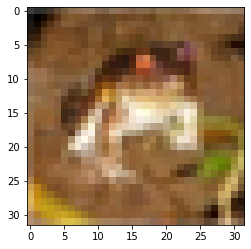

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# see the data shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print()

# show the i-th sample of the cifar-10 training set, try a different `i`
i = 0
plt.imshow(x_train[i])
print('The label of training sample %d is %s.' % (i, y_train[i]))

## 3. 範例模型

以下使用 Keras 實作兩種深度學習模型來進行 CIFAR-10 圖片分類。其中 DNN 只使用全連接層，而 CNN 多使用了卷積層。相較於 [Tensorflow 單元](/notebooks/unit/tensorflow/tenforflow.ipynb)的 MNIST 資料，CIFAR-10 的圖片比較複雜且為彩色，更能發揮卷積層的效果。也因此相較於 DNN，CNN 應該更容易得到好的結果。注意比較以下兩個程式區段，使用 CNN 時不需要將圖片 reshape 為一維向量。當然，CNN 也能處理 reshape 過的一維向量。CNN 的初學者可以參考以下連結：

* [A Beginner's Guide To Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)
* [深度學習(2)--使用Tensorflow實作卷積神經網路(Convolutional neural network，CNN)](http://arbu00.blogspot.tw/2017/03/2-tensorflowconvolutional-neural.html)

![Convolutional Neural Network](https://adeshpande3.github.io/assets/Cover.png)

In [ ]:
# DNN

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

x_tr_dnn = x_train[:10000].astype('float32')
x_te_dnn = x_test.astype('float32')

# note that the CNN version does not need to reshape the input
x_tr_dnn = x_tr_dnn.reshape(-1, 3072)
x_te_dnn = x_te_dnn.reshape(-1, 3072)

# normalize
x_tr_dnn /= 255
x_te_dnn /= 255

# one-hot encoding
y_tr_dnn = to_categorical(y_train[:10000], num_classes=10)
y_te_dnn = to_categorical(y_test, num_classes=10)

# options
epochs = 20
batch_size = 128 
learning_rate = 0.001

# model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(3072,)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# train
model.fit(x_tr_dnn, y_tr_dnn, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(x_te_dnn, y_te_dnn))

Epoch 1/20
79/79 [==============================] - 1s 14ms/step - loss: 2.1756 - accuracy: 0.2278 - val_loss: 1.9899 - val_accuracy: 0.2806
Epoch 2/20
79/79 [==============================] - 1s 10ms/step - loss: 1.9212 - accuracy: 0.3169 - val_loss: 1.8848 - val_accuracy: 0.3312
Epoch 3/20
79/79 [==============================] - 1s 11ms/step - loss: 1.8558 - accuracy: 0.3402 - val_loss: 1.9150 - val_accuracy: 0.3259
Epoch 4/20
79/79 [==============================] - 1s 11ms/step - loss: 1.8353 - accuracy: 0.3504 - val_loss: 1.8331 - val_accuracy: 0.3533
Epoch 5/20
79/79 [==============================] - 1s 11ms/step - loss: 1.7961 - accuracy: 0.3670 - val_loss: 1.8621 - val_accuracy: 0.3363
Epoch 6/20
79/79 [==============================] - 1s 11ms/step - loss: 1.7791 - accuracy: 0.3703 - val_loss: 1.8002 - val_accuracy: 0.3614
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 1.7605 - accuracy: 0.3753 - val_loss: 1.7924 - val_accuracy: 0.3665
Epoch 8/20
79

In [ ]:
# CNN

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

x_tr_cnn = x_train[:10000].astype('float32')
x_te_cnn = x_test.astype('float32')

# normalize
x_tr_cnn /= 255
x_te_cnn /= 255

# one-hot encoding
y_tr_cnn = to_categorical(y_train[:10000], num_classes=10)
y_te_cnn = to_categorical(y_test, num_classes=10)

# options
epochs = 20
batch_size = 128 
learning_rate = 0.001

# model
model = Sequential()

# the input shape for cifar-10 is (32, 32, 3)
# use `Conv2D(#neurons, (filter_size))` to add convolutionary layers
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'))

# use `MaxPooling2D()` to add pooling layers
# model.add(MaxPooling2D((2, 2)))

# TODO: add more convolutionary and/or pooling layers here

# in practice, fully-connected layers are added after convolutionary and pooling ones 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# train
model.fit(x_tr_cnn, y_tr_cnn, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(x_te_cnn, y_te_cnn))

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 1.8555 - accuracy: 0.3478 - val_loss: 1.6765 - val_accuracy: 0.4141
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 1.5077 - accuracy: 0.4776 - val_loss: 1.5525 - val_accuracy: 0.4459
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 1.3285 - accuracy: 0.5464 - val_loss: 1.4425 - val_accuracy: 0.4930
Epoch 4/20
79/79 [==============================] - 0s 5ms/step - loss: 1.1887 - accuracy: 0.5928 - val_loss: 1.4183 - val_accuracy: 0.4913
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 1.0977 - accuracy: 0.6271 - val_loss: 1.3732 - val_accuracy: 0.5104
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 0.9959 - accuracy: 0.6678 - val_loss: 1.4084 - val_accuracy: 0.5024
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 0.9332 - accuracy: 0.6888 - val_loss: 1.3980 - val_accuracy: 0.5125
Epoch 8/20
79/79 [==

## 4. 作業
若依照以上範例的設定，經過 20 輪訓練後，DNN 可以到達約 40% 的正確率，而 CNN 可以達到約 50% 的正確率。請更改 DNN 或是 CNN 的架構來改善模型。validation 的準確度即為本次作業分數

提示：
1. 調整訓練輪數(`epochs`)
2. 調整批次大小(`batch_size`)
3. 調整學習速率(`learning_rate`)
4. 增加層數
5. 調整每層的神經元數量
6. 參考經典網路架構

In [ ]:
# CNN
import keras
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize
x_train /= 255
x_test /= 255

# one-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


# model
keras.backend.clear_session()
weight_decay = 1e-4

#============================================================================================
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
#============================================================================================

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

#training
batch_size = 128

opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])


Epoch 1/125
390/390 [==============================] - 23s 60ms/step - loss: 2.0124 - accuracy: 0.3955 - val_loss: 1.5330 - val_accuracy: 0.4695
Epoch 2/125
390/390 [==============================] - 23s 58ms/step - loss: 1.3782 - accuracy: 0.5512 - val_loss: 1.6652 - val_accuracy: 0.5285
Epoch 3/125
390/390 [==============================] - 23s 59ms/step - loss: 1.1498 - accuracy: 0.6246 - val_loss: 1.0166 - val_accuracy: 0.6776
Epoch 4/125
390/390 [==============================] - 23s 58ms/step - loss: 1.0149 - accuracy: 0.6706 - val_loss: 1.3695 - val_accuracy: 0.6120
Epoch 5/125
390/390 [==============================] - 23s 58ms/step - loss: 0.9384 - accuracy: 0.6981 - val_loss: 0.9603 - val_accuracy: 0.6972
Epoch 6/125
390/390 [==============================] - 23s 58ms/step - loss: 0.8812 - accuracy: 0.7178 - val_loss: 0.8723 - val_accuracy: 0.7298
Epoch 7/125
390/390 [==============================] - 23s 58ms/step - loss: 0.8391 - accuracy: 0.7354 - val_loss: 0.9041 - val_ac